run the following two code cells so that the remaining code cells work on your

In [ ]:
import sys
from google.colab import drive

In [ ]:
# 1. Mount your Google Drive
drive.mount('/content/drive')

# 2. Add your project folder to Python's "path"
project_path = "/content/drive/MyDrive/ForestTrees/"
sys.path.append(project_path)
print(f"Added {project_path} to Python path")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Added /content/drive/MyDrive/ForestTrees/ to Python path


In [ ]:
from preprocessing import split_data
import joblib
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Loading the pipeline

In [ ]:
file_path = '/content/drive/MyDrive/ForestTrees/data/insurance.csv'
final_model_filename = 'xgboost_final_model.joblib'
model_path = project_path + final_model_filename

df = pd.read_csv(file_path)
X_train, X_test, y_train_log, y_test_log = split_data(df)

best_xgb_pipeline = joblib.load(model_path)
print(f"\nSuccessfully loaded final model from: {model_path}")


Successfully loaded final model from: /content/drive/MyDrive/ForestTrees/final_model.joblib


### Prediction and metrics

Making predictions on the Test Set (N=268)...
create_features built successfully.

--- Actual (first 5) ---
626      6748.59120
48      12629.89670
86      43578.93940
1241    49577.66240
923      4320.41085
Name: charges, dtype: float64

--- Predictions (first 5) ---
[ 6306.6436 13816.568  42872.406  47327.36    5748.4004]

XGBoost model regression metrics (on original $ scale):
Root Mean Squared Error (RMSE): $4,752.96
Mean Absolute Error (MAE): $2,092.33
Mean Squared Error (MSE): $22,590,589.71
Predicted vs. Actual Plot saved to: /content/drive/MyDrive/ForestTrees/XGBoost_Predicted_vs_Actual_Plot(with class imbalance handling).png


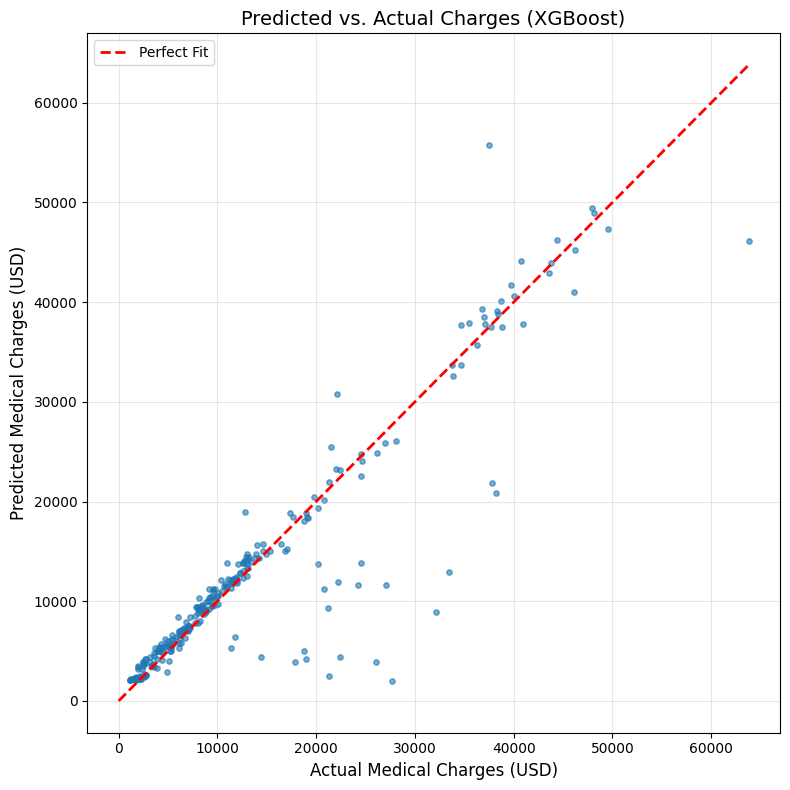

In [ ]:
print(f"Making predictions on the Test Set (N={len(X_test)})...")

# Predict using the entire pipeline (preprocessor + model)
y_pred_log = best_xgb_pipeline.predict(X_test)

# Inverse transform to original dollar scale
y_pred_dollars = np.expm1(y_pred_log)
y_test_dollars = np.expm1(y_test_log)

# First 5 y-values
print("\n--- Actual (first 5) ---")
print(y_test_dollars[:5])

# First 5 predictions
print("\n--- Predictions (first 5) ---")
print(y_pred_dollars[:5])

# Calculate final regression metrics on the original scale
final_mse = mean_squared_error(y_test_dollars, y_pred_dollars)
final_rmse = np.sqrt(final_mse)
final_mae = mean_absolute_error(y_test_dollars, y_pred_dollars)

print("\nXGBoost model regression metrics (on original $ scale):")
print(f"Root Mean Squared Error (RMSE): ${final_rmse:,.2f}")
print(f"Mean Absolute Error (MAE): ${final_mae:,.2f}")
print(f"Mean Squared Error (MSE): ${final_mse:,.2f}")

# Predicted vs. Actual Scatter Plot
# This plot visually confirms the model's fit. Points close to line y = x indicate perfect predictions
plt.figure(figsize=(8, 8))
plt.scatter(y_test_dollars, y_pred_dollars, alpha=0.6, s=15, color='#1f77b4')

max_val = max(y_test_dollars.max(), y_pred_dollars.max())
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', linewidth=2, label='Perfect Fit')

plt.title('Predicted vs. Actual Charges (XGBoost)', fontsize=14)
plt.xlabel('Actual Medical Charges (USD)', fontsize=12)
plt.ylabel('Predicted Medical Charges (USD)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plot_save_path_fit = project_path + 'XGBoost_Predicted_vs_Actual_Plot(with class imbalance handling).png'
plt.tight_layout()
plt.savefig(plot_save_path_fit)
print(f"Predicted vs. Actual Plot saved to: {plot_save_path_fit}")
plt.show()
plt.close()


# Extra stuff
(retraining model using important features)

## Retraining model using impt features identified before
- no point cause RMSE very similar

In [ ]:
# Creating dataset with only top 15 impt features

print("\n--- Feature Selection: Identifying Top 15 Features ---")
initial_xgb_model = best_xgb_pipeline.named_steps['model']
initial_preprocessor = best_xgb_pipeline.named_steps['preprocessor']

# Fully transform X_train and X_test to get the complete set of engineered features
X_train_full_transformed = initial_preprocessor.transform(X_train)
X_test_full_transformed = initial_preprocessor.transform(X_test)

# Try to retrieve feature names from the fitted preprocessor.
try:
    feature_names = initial_preprocessor.get_feature_names_out()
except AttributeError:
    # RATIONALE: Fallback logic for older scikit-learn versions (kept for robustness).
    print("ERROR: Preprocessor does not support get_feature_names_out(). Checking underlying steps...")
    col_transformer = initial_preprocessor

    if hasattr(initial_preprocessor, 'steps'):
        col_transformer = initial_preprocessor.steps[-1][1]

    try:
        feature_names = []
        for name, transformer, columns in col_transformer.transformers_:
            if transformer != 'drop':
                if hasattr(transformer, 'get_feature_names_out'):
                    feature_names.extend(transformer.get_feature_names_out(columns))
                elif hasattr(transformer, 'get_feature_names'):
                    feature_names.extend(transformer.get_feature_names(columns))
                else:
                    feature_names.extend(columns)

        if not feature_names:
            raise Exception("Feature names list is empty after secondary retrieval.")

    except Exception as e:
        print(f"CRITICAL: Secondary feature name retrieval failed: {e}. Cannot proceed.")
        sys.exit(1)

# Extract the 'gain' importance scores from the trained XGBoost model.
importance = initial_xgb_model.feature_importances_

# Create and sort a DataFrame to easily identify the top-performing features by gain.
if len(feature_names) != len(importance):
    print(f"CRITICAL ERROR: Feature name count ({len(feature_names)}) does not match importance score count ({len(importance)}). Cannot proceed with feature selection.")
    sys.exit(1)

importance_df = pd.DataFrame({'feature': feature_names, 'importance': importance})
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Select the names of the top 15 engineered features.
top_engineered_features = importance_df['feature'].head(15).tolist()

# Convert the full transformed NumPy arrays into DataFrames for easy column filtering.
X_train_full_transformed_df = pd.DataFrame(X_train_full_transformed, columns=feature_names)
X_test_full_transformed_df = pd.DataFrame(X_test_full_transformed, columns=feature_names)

# Filter the transformed DataFrames to contain ONLY the top 15 engineered features.
X_train_reduced = X_train_full_transformed_df[top_engineered_features]
X_test_reduced = X_test_full_transformed_df[top_engineered_features]

print(f"Top {len(X_train_reduced.columns)} ENGINEERED features selected: {X_train_reduced.columns.tolist()}")




--- Feature Selection: Identifying Top 15 Features ---
create_features built successfully.
create_features built successfully.
ERROR: Preprocessor does not support get_feature_names_out(). Checking underlying steps...
Top 15 ENGINEERED features selected: ['smoker_x_obese_1', 'smoker_yes', 'smoker_in_northwest_1', 'is_male_x_smoker_1', 'age_squared', 'age', 'is_obese_1', 'children_2', 'smoker_in_southeast_1', 'bmi', 'children_4', 'children_3', 'region_northwest', 'region_southeast', 'sex_male']


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform


Starting XGBoost Hyperparameter Tuning (RandomizedSearchCV) on Top 15 Features...
Training the simplified model with tuning...
Retraining and tuning complete.

--- SIMPLIFIED MODEL TUNING RESULTS ---
Best parameters found: {'colsample_bytree': np.float64(0.7888820517112247), 'learning_rate': np.float64(0.0430533878126005), 'max_depth': 3, 'n_estimators': 120}
Best Cross-Validation RMSE (Log Scale): 0.3821
Final Model Type: XGBRegressor
Making predictions on the Test Set (N=268) using the simplified model...

--- SIMPLIFIED MODEL PERFORMANCE (Top 15 Engineered Features) ---
Root Mean Squared Error (RMSE): $4,834.53  <-- BEST PREDICTION SCORE
Mean Absolute Error (MAE): $2,205.42


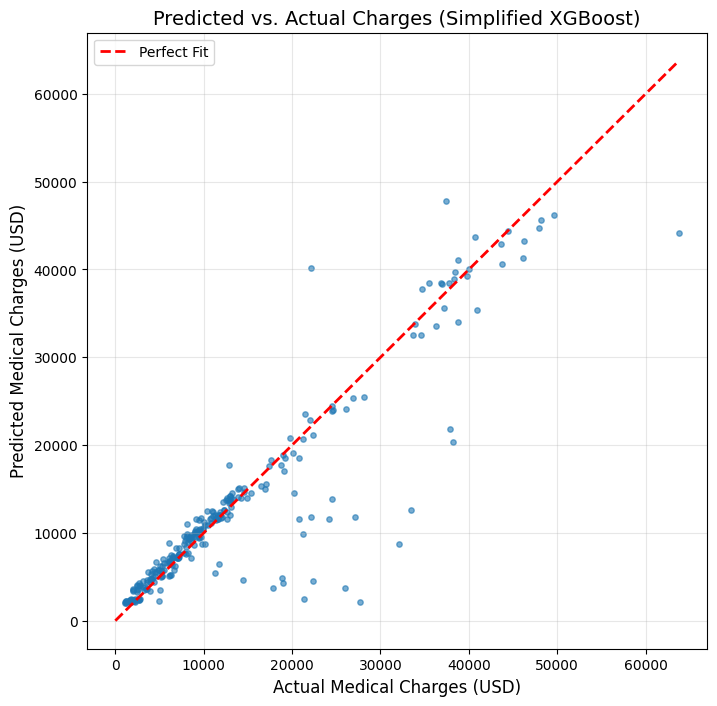

In [ ]:
# Retraining model on top 15 features

# Recalculate sample weights based on the original (unfiltered) 'smoker' column.
# This weight applies to the entire training set (1070 samples).
# The decision to use weights depends on whether 'smoker' was one of the original 6 columns.
# if 'smoker' not in X_train.columns:
#     print("WARNING: Original 'smoker' column not found for weighting. Disabling sample weighting.")
#     weights_train = np.ones(len(X_train))
# else:
#     non_smokers_count = X_train['smoker'].value_counts().get('no', 1)
#     smokers_count = X_train['smoker'].value_counts().get('yes', 1)
#     weight_ratio = non_smokers_count / smokers_count
#     # RATIONALE: Use the weights corresponding to the full X_train size
#     weights_train = np.where(X_train['smoker'] == 'yes', weight_ratio, 1)


# Define a new, simplified XGBoost model.
xgb_model_untuned = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    tree_method='hist'
)

# Define the hyperparameter search space. Use direct parameter names as the model is fit directly to pre-transformed data.
print("\nStarting XGBoost Hyperparameter Tuning (RandomizedSearchCV) on Top 15 Features...")

param_dist = {
    'n_estimators': randint(50, 200),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 8),
    'colsample_bytree': uniform(0.7, 0.3)
}

# Setup RandomizedSearchCV
# Tune for the best prediction score using negative RMSE (the lower the better)
random_search = RandomizedSearchCV(
    estimator=xgb_model_untuned,
    param_distributions=param_dist,
    n_iter=50,
    scoring='neg_root_mean_squared_error',
    cv=5,
    random_state=42,
    n_jobs=-1
)

# Fit the search object to the reduced, transformed training data, applying sample weights.
print("Training the simplified model with tuning...")
random_search.fit(X_train_reduced, y_train_log)
# Note: sample_weight is passed directly to the estimator's fit method
# random_search.fit(X_train_reduced, y_train_log, sample_weight=weights_train)

# Get the best estimator (the fully trained, tuned model)
simplified_pipeline = random_search.best_estimator_
print("Retraining and tuning complete.")

# 4.6. RATIONALE: Print Tuning Results for documentation.
print("\n--- SIMPLIFIED MODEL TUNING RESULTS ---")
best_params = random_search.best_params_
print(f"Best parameters found: {best_params}")
print(f"Best Cross-Validation RMSE (Log Scale): {-random_search.best_score_:.4f}")
print(f"Final Model Type: {type(simplified_pipeline).__name__}")


# --- 5. PREDICTION & METRIC CALCULATION (Simplified Model Performance) ---

print(f"Making predictions on the Test Set (N={len(X_test_reduced)}) using the simplified model...")

# RATIONALE: Predict using the simplified model on the reduced, transformed test data.
y_pred_log = simplified_pipeline.predict(X_test_reduced)

# RATIONALE: Inverse transform the predictions and actuals.
y_pred_orig = np.expm1(y_pred_log)
y_test_orig = np.expm1(y_test_log)

# RATIONALE: Calculate final regression metrics on the original dollar scale.
final_mse = mean_squared_error(y_test_orig, y_pred_orig)
final_rmse = np.sqrt(final_mse)
final_mae = mean_absolute_error(y_test_orig, y_pred_orig)


print("\n--- SIMPLIFIED MODEL PERFORMANCE (Top 15 Engineered Features) ---")
print(f"Root Mean Squared Error (RMSE): ${final_rmse:,.2f}  <-- BEST PREDICTION SCORE")
print(f"Mean Absolute Error (MAE): ${final_mae:,.2f}")


# 5.4. VISUALIZATION: Predicted vs. Actual Scatter Plot
plt.figure(figsize=(8, 8))
plt.scatter(y_test_orig, y_pred_orig, alpha=0.6, s=15, color='#1f77b4')

max_val = max(y_test_orig.max(), y_pred_orig.max())
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', linewidth=2, label='Perfect Fit')

plt.title('Predicted vs. Actual Charges (Simplified XGBoost)', fontsize=14)
plt.xlabel('Actual Medical Charges (USD)', fontsize=12)
plt.ylabel('Predicted Medical Charges (USD)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()